## XGBOOST

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import xgboost as xgb
from statsmodels.tsa.stattools import adfuller
import warnings
from nyoka import xgboost_to_pmml
from sklearn2pmml import sklearn2pmml
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn.preprocessing import StandardScaler
import os
import xgboost as xgb
warnings.filterwarnings('ignore')

##### Read data

In [164]:
df = pd.read_csv("TransformedData.csv")
df.head()

,Posted Time,District Name,Price per m2
0,2024-12-01,Huyện Hòa Vang,0.103732
1,2024-12-02,Huyện Hòa Vang,0.103732
2,2024-12-03,Huyện Hòa Vang,0.103732
3,2024-12-04,Huyện Hòa Vang,0.103732
4,2024-12-05,Huyện Hòa Vang,0.103227


#### Convert date column to datetime format if not already

In [ ]:
if not pd.api.types.is_datetime64_any_dtype(df['Posted Time']):
    df['Posted Time'] = pd.to_datetime(df['Posted Time'])

# Xem các quận/huyện có trong dữ liệu
districts = df['District Name'].unique()
print(f"Các quận/huyện trong dữ liệu: {districts}")

Các quận/huyện trong dữ liệu: ['Huyện Hòa Vang' 'Quận Cẩm Lệ' 'Quận Hải Châu' 'Quận Liên Chiểu'
 'Quận Ngũ Hành Sơn' 'Quận Sơn Trà' 'Quận Thanh Khê']


#### Create time features

In [ ]:
def create_time_features(df):
    """
    Tạo các đặc trưng thời gian cho mô hình XGBoost
    
    Parameters:
    df (DataFrame): DataFrame gốc
    
    Returns:
    DataFrame: DataFrame với các đặc trưng thời gian mới
    """
    df_copy = df.copy()
    
    # Trích xuất các thành phần thời gian
    df_copy['year'] = df_copy['Posted Time'].dt.year
    df_copy['month'] = df_copy['Posted Time'].dt.month
    df_copy['day'] = df_copy['Posted Time'].dt.day
    df_copy['dayofweek'] = df_copy['Posted Time'].dt.dayofweek
    df_copy['quarter'] = df_copy['Posted Time'].dt.quarter
    
    # Tạo đặc trưng ngày của năm
    df_copy['dayofyear'] = df_copy['Posted Time'].dt.dayofyear
    
    # Tạo biến chỉ báo cho các ngày cuối tuần
    df_copy['is_weekend'] = df_copy['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    
    # Biến chỉ báo theo mùa (tùy chỉnh theo ngữ cảnh Việt Nam)
    # Mùa xuân (tháng 1-3), Mùa hè (tháng 4-6), Mùa thu (tháng 7-9), Mùa đông (tháng 10-12)
    season_dict = {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 2, 8: 2, 9: 2, 10: 3, 11: 3, 12: 3}
    df_copy['season'] = df_copy['month'].map(season_dict)
    
    # Tính thời gian trôi qua từ ngày đầu tiên trong dữ liệu
    min_date = df_copy['Posted Time'].min()
    df_copy['days_from_min'] = (df_copy['Posted Time'] - min_date).dt.days
    
    # Tạo các biến sin và cos của tháng để nắm bắt tính chu kỳ
    df_copy['month_sin'] = np.sin(2 * np.pi * df_copy['month'] / 12)
    df_copy['month_cos'] = np.cos(2 * np.pi * df_copy['month'] / 12)
    
    return df_copy

#### Tạo đặc trưng lag và rolling cho từng quận

In [ ]:
def create_lag_features(district_df, lag_days=[7, 14, 30], window_sizes=[7, 14, 30]):
    """
    Tạo các đặc trưng lag và rolling cho một quận
    
    Parameters:
    district_df (DataFrame): DataFrame của một quận
    lag_days (list): Danh sách số ngày lag
    window_sizes (list): Danh sách kích thước cửa sổ cho rolling
    
    Returns:
    DataFrame: DataFrame với các đặc trưng lag và rolling
    """
    df_copy = district_df.copy().sort_values('Posted Time')
    
    # Tạo đặc trưng lag
    for lag in lag_days:
        df_copy[f'price_lag_{lag}'] = df_copy['Price per m2'].shift(lag)
    
    # Tạo đặc trưng rolling mean
    for window in window_sizes:
        df_copy[f'price_rolling_mean_{window}'] = df_copy['Price per m2'].rolling(window=window).mean()
        df_copy[f'price_rolling_std_{window}'] = df_copy['Price per m2'].rolling(window=window).std()
        
    # Tạo đặc trưng chênh lệch giá
    df_copy['price_diff_1'] = df_copy['Price per m2'].diff(1)
    df_copy['price_diff_7'] = df_copy['Price per m2'].diff(7)
    
    # Tính tốc độ thay đổi giá theo phần trăm
    df_copy['price_pct_change_1'] = df_copy['Price per m2'].pct_change(1)
    df_copy['price_pct_change_7'] = df_copy['Price per m2'].pct_change(7)
    
    # Điền các giá trị NaN bằng 0
    df_copy = df_copy.fillna(0)
    
    return df_copy

#### Split the data into training set and test set for each district

In [ ]:
def split_train_test(data, test_size=0.2):
    """
    Chia dữ liệu thành tập huấn luyện và tập kiểm tra cho từng quận
    
    Parameters:
    data (DataFrame): DataFrame gốc
    test_size (float): Tỷ lệ dữ liệu để kiểm tra
    
    Returns:
    dict: Dictionary chứa dữ liệu đã chia của các quận
    """
    # Dictionary lưu trữ dữ liệu đã chia của các quận
    district_data = {}
    
    for district in districts:
        # Lọc dữ liệu cho quận cụ thể
        district_df = data[data['District Name'] == district].copy()
        
        # Sắp xếp dữ liệu theo thời gian
        district_df = district_df.sort_values('Posted Time')
        
        # Tạo các đặc trưng thời gian
        district_df = create_time_features(district_df)
        
        # Tạo các đặc trưng lag và rolling
        district_df = create_lag_features(district_df)
        
        # Chia dữ liệu thành tập train và test theo thời gian
        train_size = int(len(district_df) * (1 - test_size))
        train_df = district_df.iloc[:train_size]
        test_df = district_df.iloc[train_size:]
        
        # Lưu vào dictionary
        district_data[district] = {
            'full_df': district_df,
            'train_df': train_df,
            'test_df': test_df
        }
    
    return district_data
  
district_datasets = split_train_test(df, test_size=0.2)

#### XGBoost model building function for each district

In [170]:
def build_xgboost_model(district, district_data):
    """
    Xây dựng mô hình XGBoost cho một quận cụ thể
    
    Parameters:
    district (str): Tên quận
    district_data (dict): Dữ liệu của quận
    
    Returns:
    dict: Dictionary chứa mô hình và các thông tin liên quan
    """
    print(f"Đang xây dựng mô hình cho {district}...")
    
    # Lấy dữ liệu huấn luyện và kiểm tra
    train_df = district_data['train_df']
    test_df = district_data['test_df']
    
    # Xác định các đặc trưng và biến mục tiêu
    feature_columns = [col for col in train_df.columns if col not in ['District Name', 'Posted Time', 'Price per m2']]
    target_column = 'Price per m2'
    
    X_train = train_df[feature_columns]
    y_train = train_df[target_column]
    
    X_test = test_df[feature_columns]
    y_test = test_df[target_column]
    
    # Xử lý giá trị vô hạn và thiếu
    X_train = X_train.replace([np.inf, -np.inf], np.nan).dropna()
    y_train = y_train.loc[X_train.index]  # Đồng bộ chỉ số sau khi dropna

    X_test = X_test.replace([np.inf, -np.inf], np.nan).dropna()
    y_test = y_test.loc[X_test.index]
    
    # Xác định tham số cho XGBoost
    params = {
        'objective': 'reg:squarederror',
        'learning_rate': 0.1,
        'max_depth': 6,
        'min_child_weight': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0,
        'n_estimators': 200,
        'random_state': 42
    }
    
    # Khởi tạo và huấn luyện mô hình
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    
    # Dự đoán trên tập huấn luyện và kiểm tra
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Tính các chỉ số đánh giá
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    train_mae = mean_absolute_error(y_train, train_pred)
    test_mae = mean_absolute_error(y_test, test_pred)
    
    # Tạo DataFrame dự đoán
    test_df_pred = test_df.copy()
    test_df_pred['predicted'] = test_pred
    
    print(f"Kết quả cho {district}:")
    print(f"RMSE train: {train_rmse:.4f}, RMSE test: {test_rmse:.4f}")
    print(f"MAE train: {train_mae:.4f}, MAE test: {test_mae:.4f}")
    
    return {
        'district': district,
        'model': model,
        'feature_columns': feature_columns,
        'train_metrics': {
            'rmse': train_rmse,
            'mae': train_mae
        },
        'test_metrics': {
            'rmse': test_rmse,
            'mae': test_mae
        },
        'test_predictions': test_df_pred
    }

In [ ]:
def build_all_models(district_datasets):
    """
    Xây dựng mô hình XGBoost cho tất cả các quận
    
    Parameters:
    district_datasets (dict): Dictionary chứa dữ liệu của các quận
    
    Returns:
    dict: Dictionary chứa các mô hình đã huấn luyện
    """
    models = {}
    
    for district in districts:
        if district in district_datasets:
            model_info = build_xgboost_model(district, district_datasets[district])
            models[district] = model_info
    
    return models

In [ ]:
district_models = build_all_models(district_datasets)

Đang xây dựng mô hình cho Huyện Hòa Vang...
Kết quả cho Huyện Hòa Vang:
RMSE train: 0.0004, RMSE test: 0.0088
MAE train: 0.0003, MAE test: 0.0068
Đang xây dựng mô hình cho Quận Cẩm Lệ...
Kết quả cho Quận Cẩm Lệ:
RMSE train: 0.0005, RMSE test: 0.0192
MAE train: 0.0004, MAE test: 0.0165
Đang xây dựng mô hình cho Quận Hải Châu...
Kết quả cho Quận Hải Châu:
RMSE train: 0.0005, RMSE test: 0.0611
MAE train: 0.0004, MAE test: 0.0518
Đang xây dựng mô hình cho Quận Liên Chiểu...
Kết quả cho Quận Liên Chiểu:
RMSE train: 0.0005, RMSE test: 0.0232
MAE train: 0.0003, MAE test: 0.0184
Đang xây dựng mô hình cho Quận Ngũ Hành Sơn...
Kết quả cho Quận Ngũ Hành Sơn:
RMSE train: 0.0005, RMSE test: 0.0303
MAE train: 0.0004, MAE test: 0.0272
Đang xây dựng mô hình cho Quận Sơn Trà...
Kết quả cho Quận Sơn Trà:
RMSE train: 0.0005, RMSE test: 0.0180
MAE train: 0.0003, MAE test: 0.0136
Đang xây dựng mô hình cho Quận Thanh Khê...
Kết quả cho Quận Thanh Khê:
RMSE train: 0.0005, RMSE test: 0.0514
MAE train: 0.0004,

#### Model Evaluation

In [173]:
def plot_model_evaluation(models):
    """
    Vẽ biểu đồ so sánh hiệu suất các mô hình
    
    Parameters:
    models (dict): Dictionary chứa các mô hình đã huấn luyện
    """
    # Tạo DataFrame kết quả đánh giá
    records = []
    
    for district, model_info in models.items():
        records.append({
            'District': district,
            'Train RMSE': model_info['train_metrics']['rmse'],
            'Test RMSE': model_info['test_metrics']['rmse'],
            'Train MAE': model_info['train_metrics']['mae'],
            'Test MAE': model_info['test_metrics']['mae']
        })
    
    eval_df = pd.DataFrame(records)
    
    # Vẽ biểu đồ RMSE
    plt.figure(figsize=(12, 6))
    
    x = np.arange(len(eval_df))
    width = 0.35
    
    plt.bar(x - width/2, eval_df['Train RMSE'], width, label='Train RMSE')
    plt.bar(x + width/2, eval_df['Test RMSE'], width, label='Test RMSE')
    
    plt.xlabel('Quận/Huyện')
    plt.ylabel('RMSE')
    plt.title('So sánh RMSE giữa các quận')
    plt.xticks(x, eval_df['District'], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Vẽ biểu đồ MAE
    plt.figure(figsize=(12, 6))
    
    plt.bar(x - width/2, eval_df['Train MAE'], width, label='Train MAE')
    plt.bar(x + width/2, eval_df['Test MAE'], width, label='Test MAE')
    
    plt.xlabel('Quận/Huyện')
    plt.ylabel('MAE')
    plt.title('So sánh MAE giữa các quận')
    plt.xticks(x, eval_df['District'], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return eval_df

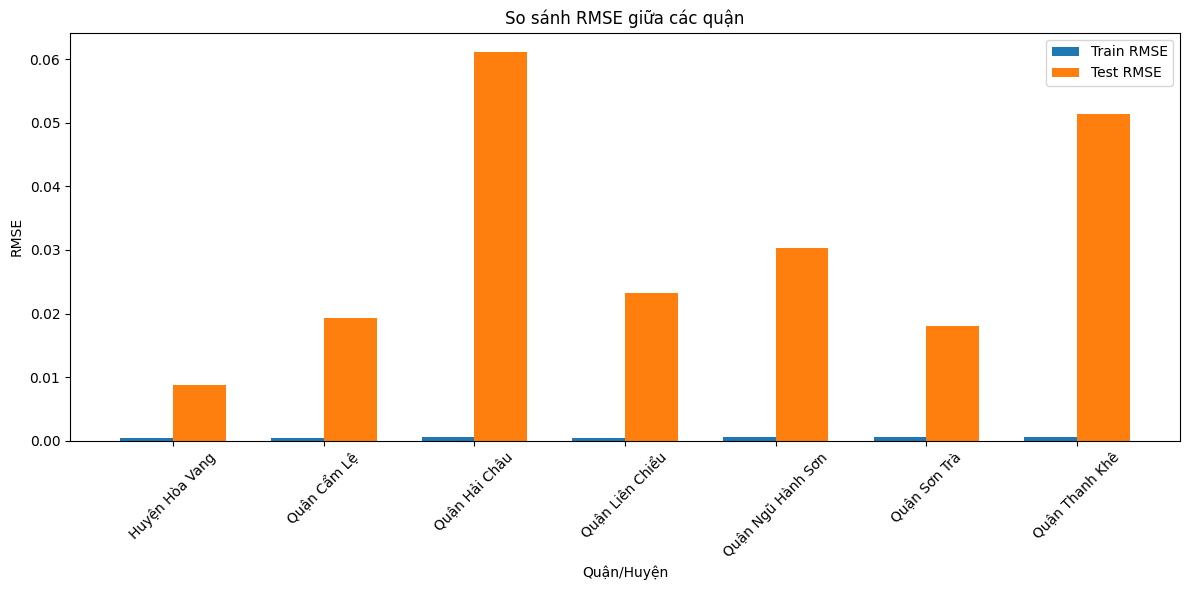

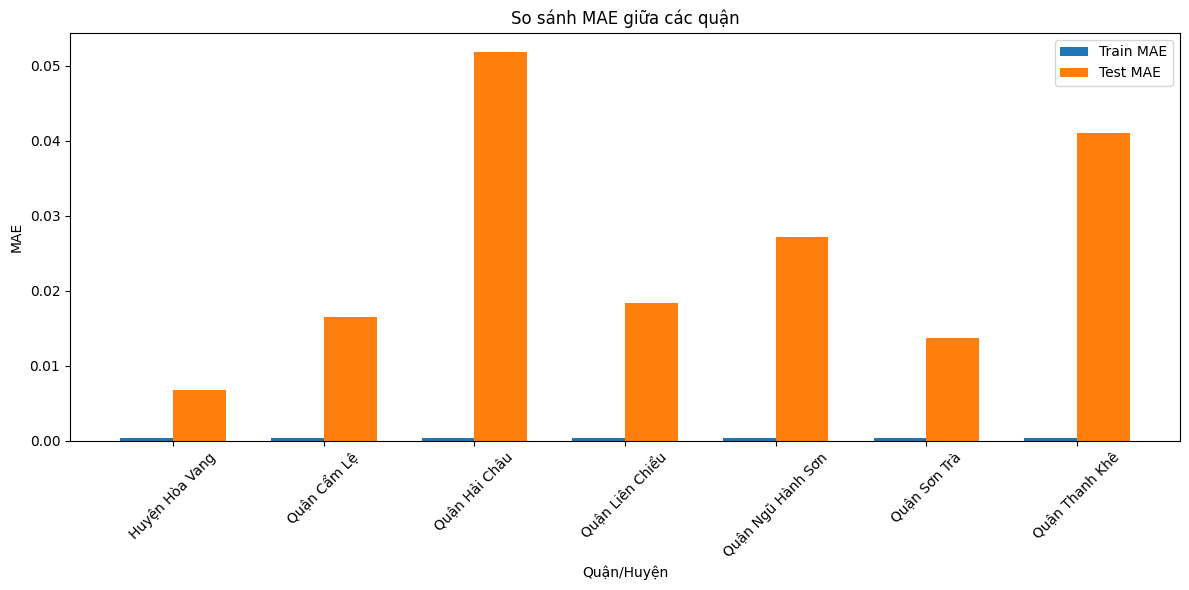

In [174]:
evaluation_df = plot_model_evaluation(district_models)

In [175]:
# Hàm trực quan hóa kết quả dự báo
def plot_prediction_results(district, model_info):
    """
    Vẽ biểu đồ kết quả dự báo cho một quận
    
    Parameters:
    district (str): Tên quận
    model_info (dict): Thông tin mô hình
    """
    # Lấy dữ liệu dự báo
    test_df = model_info['test_predictions']
    
    # Vẽ biểu đồ
    plt.figure(figsize=(14, 6))
    
    plt.plot(test_df['Posted Time'], test_df['Price per m2'], 'bo-', label='Giá thực tế')
    plt.plot(test_df['Posted Time'], test_df['predicted'], 'ro-', label='Giá dự báo')
    
    plt.title(f'So sánh giá dự báo và giá thực tế cho {district}')
    plt.xlabel('Thời gian')
    plt.ylabel('Giá (đơn vị/m2)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

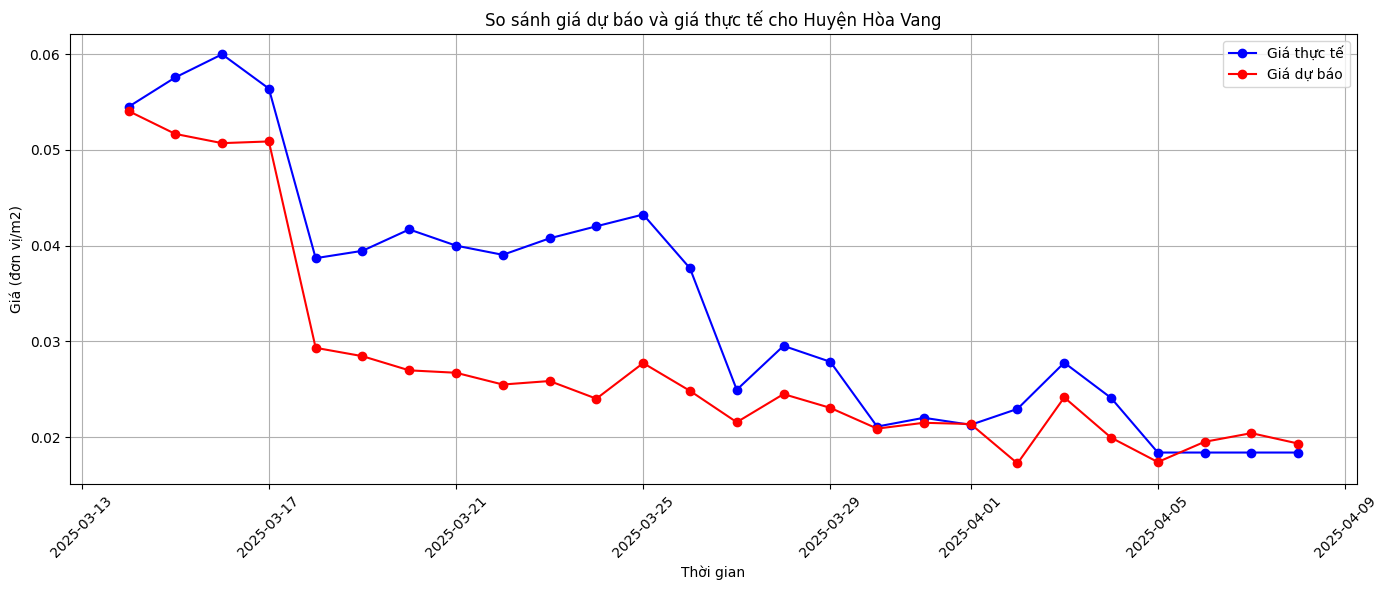

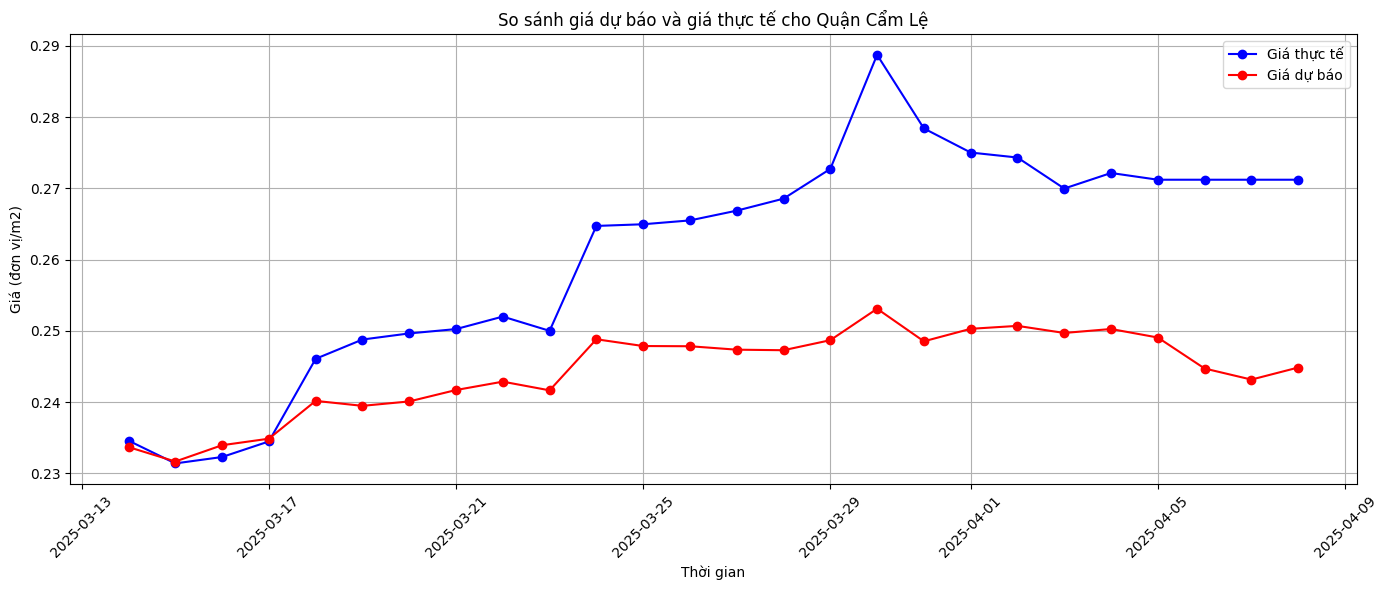

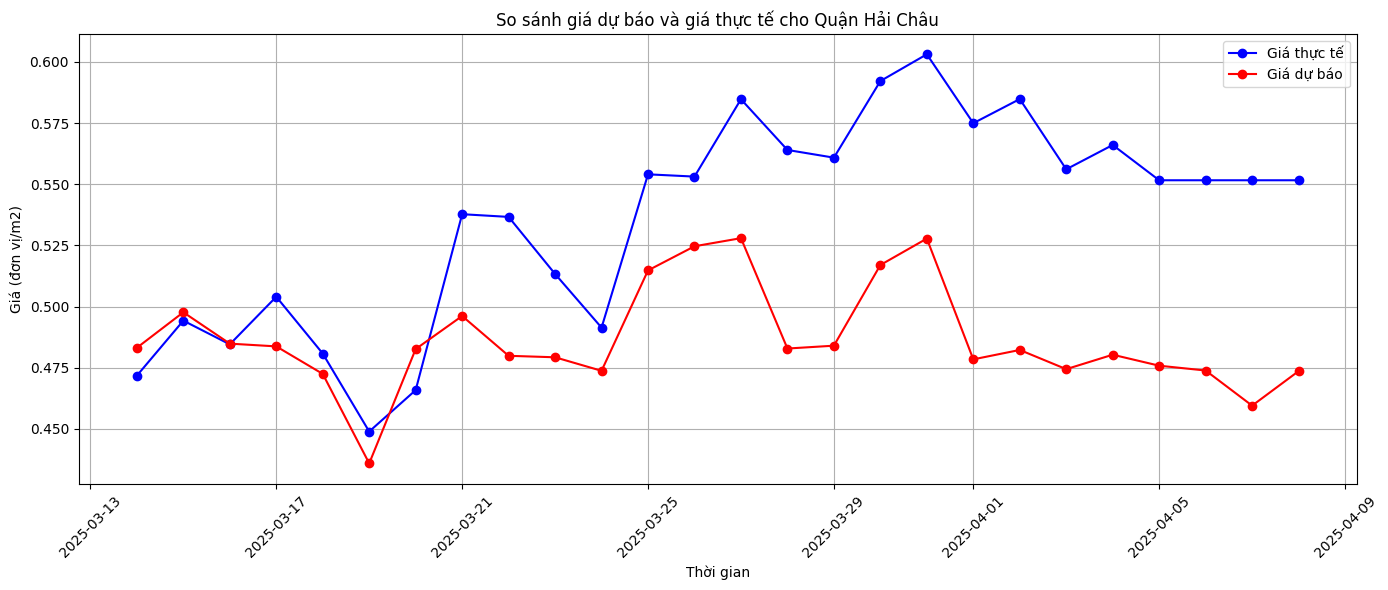

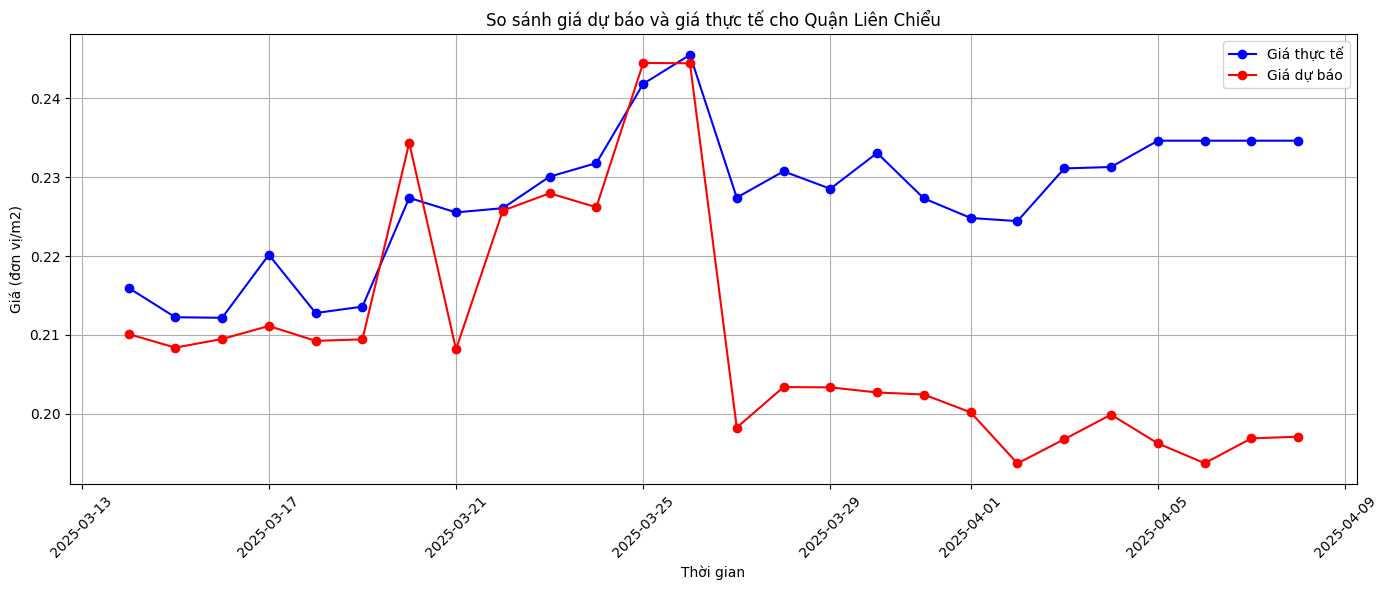

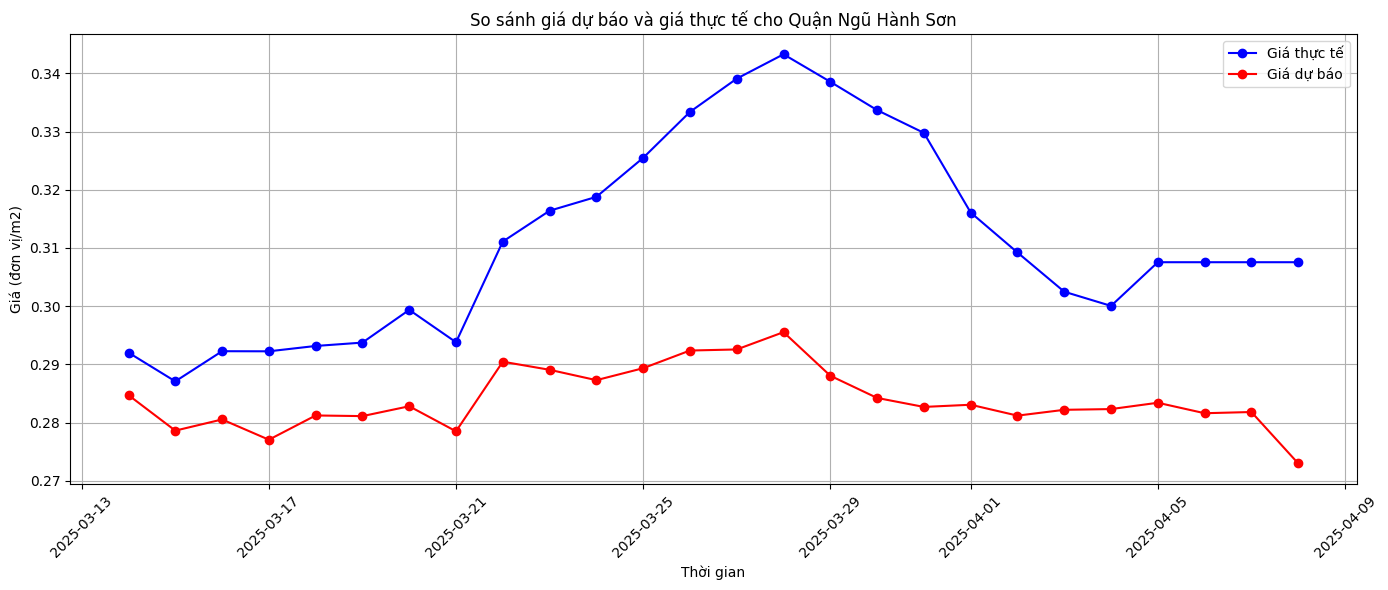

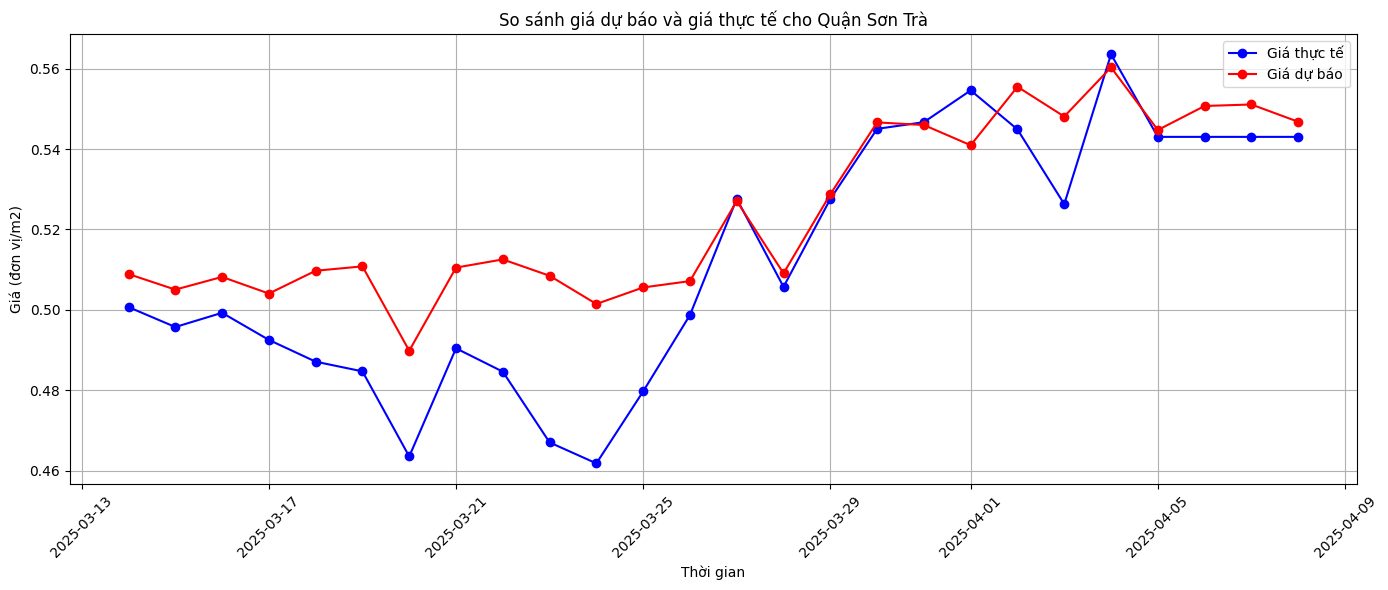

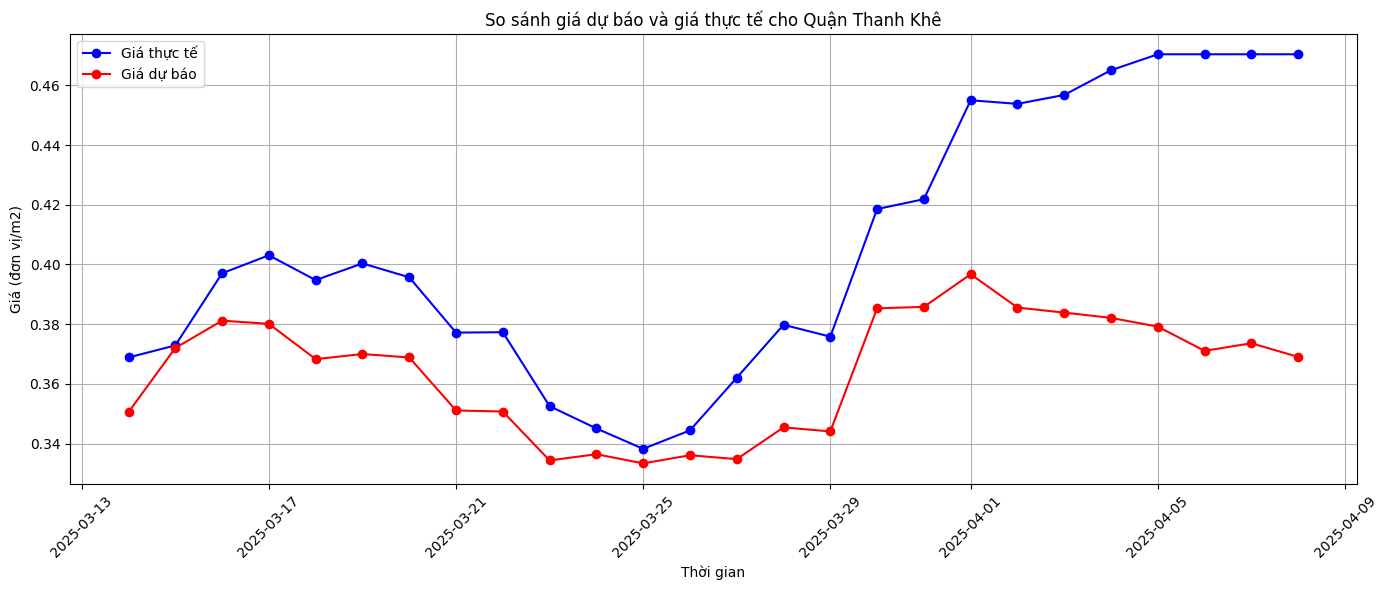

In [176]:
# Vẽ kết quả cho tất cả các quận
for district, model_info in district_models.items():
    plot_prediction_results(district, model_info)

#### Analyze the importance of features

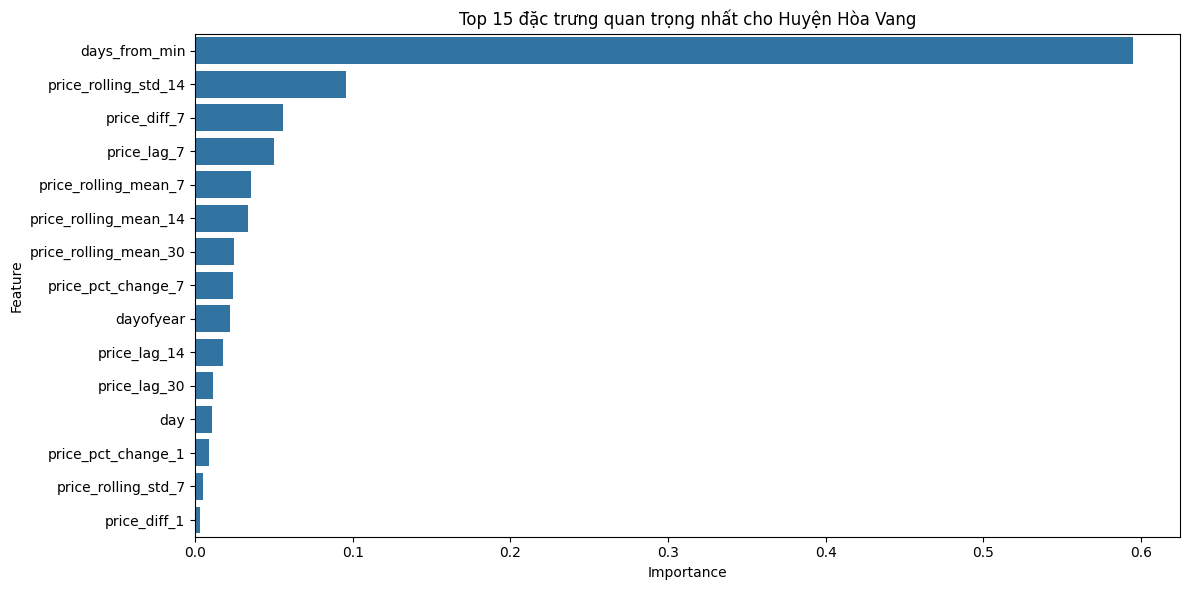

In [ ]:
def plot_feature_importance(district, model_info):
    """
    Vẽ biểu đồ mức độ quan trọng của các đặc trưng
    
    Parameters:
    district (str): Tên quận
    model_info (dict): Thông tin mô hình
    """
    model = model_info['model']
    feature_columns = model_info['feature_columns']
    
    # Lấy mức độ quan trọng
    importance = model.feature_importances_
    
    # Tạo DataFrame
    feat_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': importance
    })
    feat_importance = feat_importance.sort_values('Importance', ascending=False)
    
    # Vẽ biểu đồ top 15 đặc trưng quan trọng nhất
    plt.figure(figsize=(12, 6))
    
    top_n = min(15, len(feat_importance))
    top_features = feat_importance.head(top_n)
    
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title(f'Top {top_n} đặc trưng quan trọng nhất cho {district}')
    plt.tight_layout()
    plt.show()
    
    return feat_importance

# Vẽ mức độ quan trọng của đặc trưng cho quận đầu tiên
selected_district = districts[0]  # Thay đổi theo nhu cầu
feature_importance = plot_feature_importance(selected_district, district_models[selected_district])

#### Future forecast function

In [ ]:
def forecast_future(district, model_info, start_date, end_date):
    """
    Dự báo giá trong tương lai cho một quận
    
    Parameters:
    district (str): Tên quận
    model_info (dict): Thông tin mô hình
    start_date (str): Ngày bắt đầu dự báo (YYYY-MM-DD)
    end_date (str): Ngày kết thúc dự báo (YYYY-MM-DD)
    
    Returns:
    DataFrame: Kết quả dự báo
    """
    # Lấy mô hình và các thông tin liên quan
    model = model_info['model']
    feature_columns = model_info['feature_columns']
    full_df = district_datasets[district]['full_df']
    
    # Chuyển đổi ngày
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    # Tạo DataFrame cho khoảng thời gian dự báo
    future_dates = pd.date_range(start=start, end=end)
    future_df = pd.DataFrame({'Posted Time': future_dates})
    future_df['District Name'] = district
    
    # Tạo các đặc trưng thời gian cho dữ liệu tương lai
    future_df = create_time_features(future_df)
    
    # Tạo các đặc trưng lag và rolling dựa trên dữ liệu lịch sử
    # Đây là phần tricky nhất
    # Chúng ta cần join dữ liệu lịch sử để tính các giá trị lag và rolling

    # Sắp xếp dữ liệu lịch sử theo thời gian
    hist_df = full_df.sort_values('Posted Time')
    last_price = hist_df['Price per m2'].iloc[-1]
    
    # Tạo DataFrame kết hợp
    combined_df = pd.concat([hist_df, future_df], ignore_index=True)
    combined_df = combined_df.sort_values('Posted Time')
    
    # Tạo đặc trưng lag và rolling cho dữ liệu kết hợp
    combined_df = create_lag_features(combined_df)
    
    # Tách phần dữ liệu tương lai
    future_with_features = combined_df[combined_df['Posted Time'] >= start].copy()
    
    # Xử lý trường hợp không có dữ liệu giá
    if 'Price per m2' not in future_with_features.columns:
        future_with_features['Price per m2'] = np.nan
    
    # Chuẩn bị dữ liệu cho dự báo
    X_future = future_with_features[feature_columns]
    
    # Lấy dự báo
    future_predictions = model.predict(X_future)
    
    # Tạo DataFrame kết quả
    forecast_df = pd.DataFrame({
        'Ngày': future_with_features['Posted Time'],
        'Quận': district,
        'Giá dự báo': future_predictions
    })
    
    return forecast_df

In [179]:
selected_district = districts[0]  # Thay đổi theo nhu cầu
start_date = '2025-06-01'         # Thay đổi theo nhu cầu
end_date = '2025-06-30'           # Thay đổi theo nhu cầu

forecast_result = forecast_future(
    selected_district,
    district_models[selected_district],
    start_date,
    end_date
)

print(f"Dự báo giá cho {selected_district} từ {start_date} đến {end_date}:")
forecast_result.head(10)  

Dự báo giá cho Huyện Hòa Vang từ 2025-06-01 đến 2025-06-30:


,Ngày,Quận,Giá dự báo
129,2025-06-01,Huyện Hòa Vang,0.093992
130,2025-06-02,Huyện Hòa Vang,0.094254
131,2025-06-03,Huyện Hòa Vang,0.094266
132,2025-06-04,Huyện Hòa Vang,0.094125
133,2025-06-05,Huyện Hòa Vang,0.093980
134,2025-06-06,Huyện Hòa Vang,0.093820
135,2025-06-07,Huyện Hòa Vang,0.093850
136,2025-06-08,Huyện Hòa Vang,0.103632
137,2025-06-09,Huyện Hòa Vang,0.084081
138,2025-06-10,Huyện Hòa Vang,0.038472


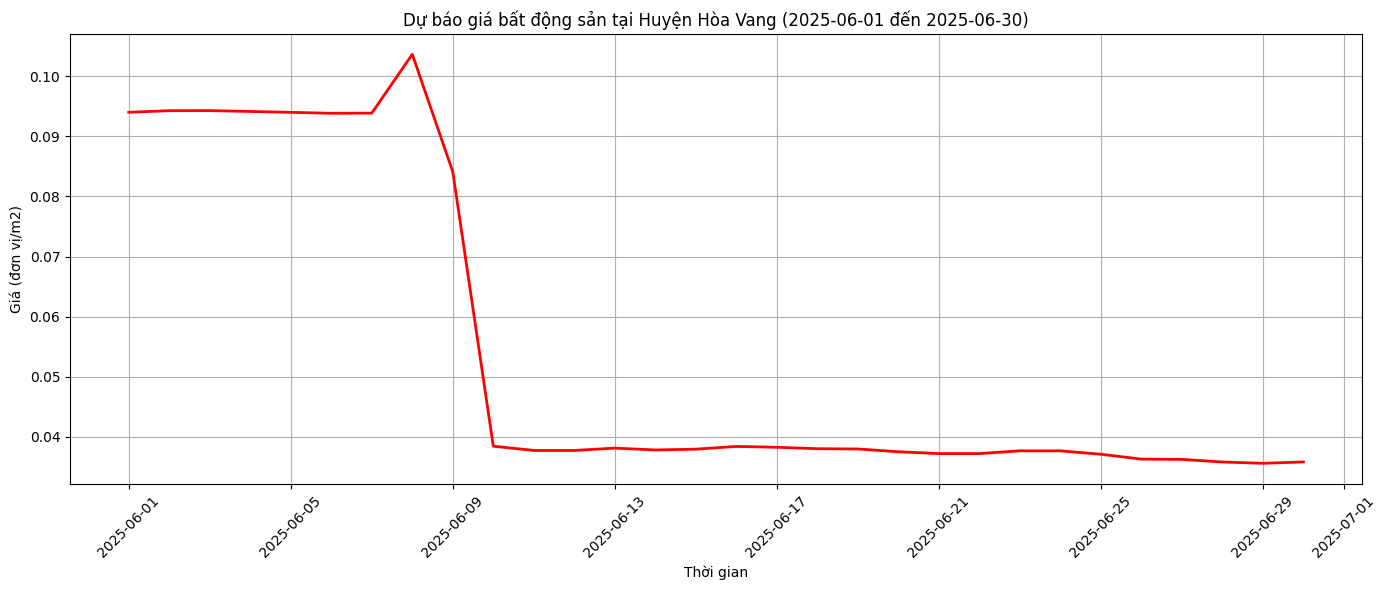

In [180]:
# Vẽ biểu đồ dự báo
plt.figure(figsize=(14, 6))

plt.plot(forecast_result['Ngày'], forecast_result['Giá dự báo'], 'r-', linewidth=2)

plt.title(f'Dự báo giá bất động sản tại {selected_district} ({start_date} đến {end_date})')
plt.xlabel('Thời gian')
plt.ylabel('Giá (đơn vị/m2)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
def forecast_all_districts(models, start_date, end_date):
    """
    Dự báo giá cho tất cả các quận trong một khoảng thời gian
    
    Parameters:
    models (dict): Dictionary chứa các mô hình đã huấn luyện
    start_date (str): Ngày bắt đầu (định dạng 'YYYY-MM-DD')
    end_date (str): Ngày kết thúc (định dạng 'YYYY-MM-DD')
    
    Returns:
    dict: Kết quả dự báo cho từng quận
    """
    results = {}
    
    for district, model_info in models.items():
        results[district] = forecast_future(
            district, model_info, start_date, end_date
        )
    
    return results

# Dự báo cho tất cả các quận
all_forecasts = forecast_all_districts(district_models, start_date, end_date)

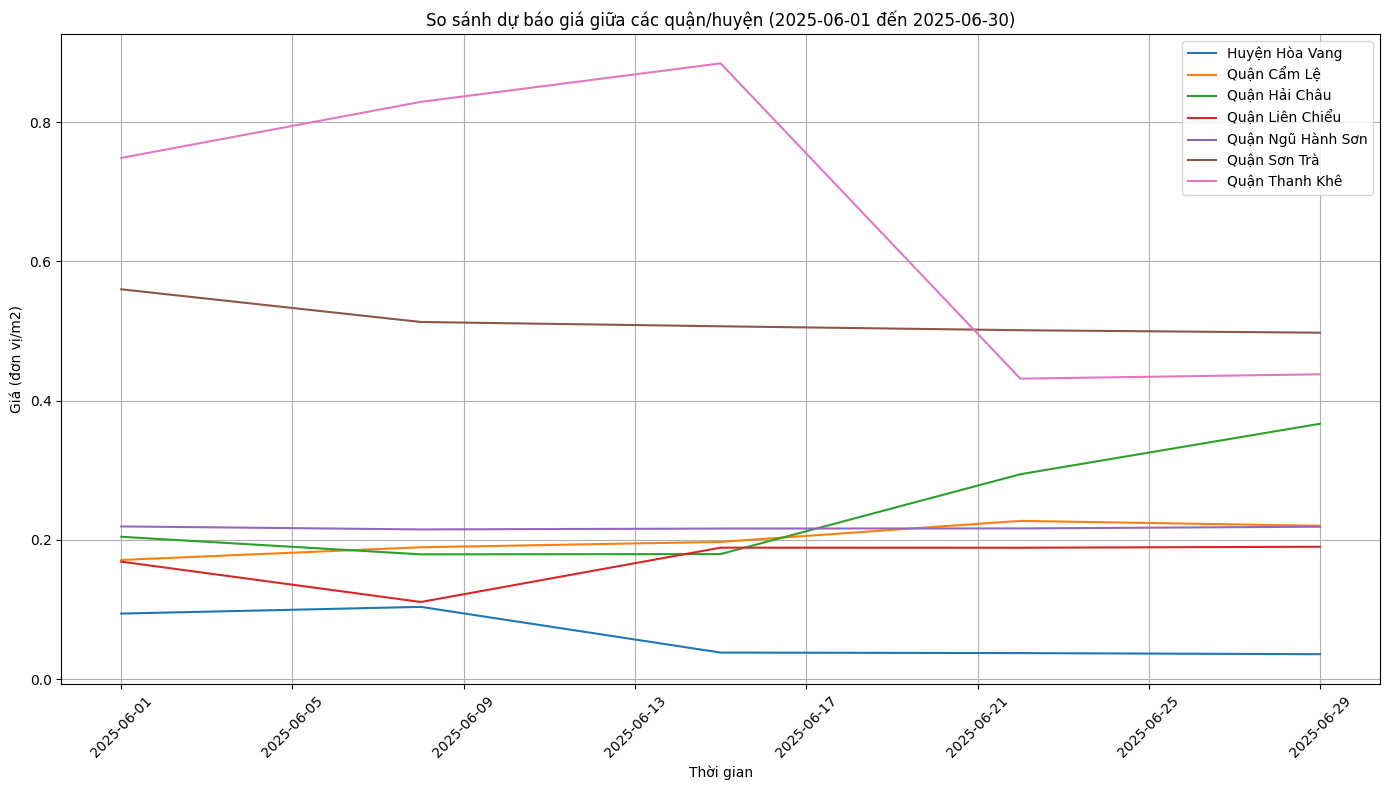

In [ ]:
plt.figure(figsize=(14, 8))

# Lọc các ngày để biểu đồ dễ đọc hơn
sample_dates = pd.date_range(start=start_date, end=end_date, freq='W')  # Lấy mẫu theo tuần

for district, forecast_df in all_forecasts.items():
    # Lọc dữ liệu
    sampled_forecast = forecast_df[forecast_df['Ngày'].isin(sample_dates)]
    plt.plot(sampled_forecast['Ngày'], sampled_forecast['Giá dự báo'], label=district)

plt.title(f'So sánh dự báo giá giữa các quận/huyện ({start_date} đến {end_date})')
plt.xlabel('Thời gian')
plt.ylabel('Giá (đơn vị/m2)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [183]:
from sklearn.pipeline import Pipeline
from nyoka import xgboost_to_pmml

import os
output_folder = "xgboost_pmml_models"
os.makedirs(output_folder, exist_ok=True)

for district, model_info in district_models.items():
    model = model_info['model']
    feature_names = model_info['feature_columns']
    target_name = 'Price per m2'

    # Bọc mô hình vào Pipeline
    pipeline = Pipeline([("xgb_model", model)])

    pmml_file_name = f"{district.replace(' ', '_')}_xgboost_model.pmml"
    pmml_file_path = os.path.join(output_folder, pmml_file_name)

    # Lưu dưới dạng PMML
    xgboost_to_pmml(pipeline, feature_names, target_name, pmml_file_path)

    print(f"Đã lưu PMML: {pmml_file_path}")


Đã lưu PMML: xgboost_pmml_models\Huyện_Hòa_Vang_xgboost_model.pmml
Đã lưu PMML: xgboost_pmml_models\Quận_Cẩm_Lệ_xgboost_model.pmml
Đã lưu PMML: xgboost_pmml_models\Quận_Hải_Châu_xgboost_model.pmml
Đã lưu PMML: xgboost_pmml_models\Quận_Liên_Chiểu_xgboost_model.pmml
Đã lưu PMML: xgboost_pmml_models\Quận_Ngũ_Hành_Sơn_xgboost_model.pmml
Đã lưu PMML: xgboost_pmml_models\Quận_Sơn_Trà_xgboost_model.pmml
Đã lưu PMML: xgboost_pmml_models\Quận_Thanh_Khê_xgboost_model.pmml
